In [258]:
import pandas as pd
pd.options.display.max_rows    = 999
pd.options.display.max_columns = 999

In [259]:
###############################
#                             #
#        ENCODE FACTORS       #
#                             #
###############################

# performs label encoding
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def label_encoding(df_train, df_valid, df_test):
    
    factors = df_train.select_dtypes('object').columns
    
    lbl = LabelEncoder()

    for f in factors:        
        #print(f)
        lbl.fit(list(df_train[f].values)+ list(df_test[f].values) + list(df_valid[f].values) )
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_valid[f] = lbl.transform(list(df_valid[f].values))
        df_test[f]  = lbl.transform(list(df_test[f].values))

    return df_train, df_valid, df_test

from sklearn import base
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] =  X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName, np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

In [260]:
from math import sqrt
from scipy.stats.mstats import winsorize
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
%matplotlib inline

import os
import time
import datetime
import random
import multiprocessing
import pickle

import scipy.stats

import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

In [261]:
############ RANDOMNESS

# seed function
def seed_everything(seed = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 42
seed_everything(seed)

### IMPORT

In [262]:
############ DATA IMPORT

# id data
train = pd.read_csv('../raw/training.csv')
test  = pd.read_csv('../raw/unlabeled.csv')


# check dimensions
print(train.shape)
print(test.shape)

train = train[-train['hospital_death'].isnull()]

(110369, 186)
(39308, 186)


In [263]:
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

Mem. usage decreased to 37.78 Mb (71.1% reduction)
Mem. usage decreased to 16.01 Mb (71.3% reduction)


In [264]:
train['NAs'] = train.isnull().sum(axis=1)
test['NAs']  = test.isnull().sum(axis=1)

In [265]:
y     = train['hospital_death']
train = train.drop('hospital_death', axis=1)

In [266]:
train['apache_4a_hospital_death_prob'][train['apache_4a_hospital_death_prob']==-1] = np.nan
test['apache_4a_hospital_death_prob'][test['apache_4a_hospital_death_prob']==-1]   = np.nan

train['apache_4a_icu_death_prob'][train['apache_4a_icu_death_prob']==-1] = np.nan
test['apache_4a_icu_death_prob'][test['apache_4a_icu_death_prob']==-1]   = np.nan

In [267]:
train = train.replace([np.inf, -np.inf], np.nan)
test  = test.replace([np.inf, -np.inf], np.nan)

In [268]:
train[train['pre_icu_los_days']<0]['pre_icu_los_days'] = 0
test[test['pre_icu_los_days']<0]['pre_icu_los_days'] = 0

In [269]:
train['apache_prob_prod'] = train['apache_4a_hospital_death_prob'] * train[ 'apache_4a_icu_death_prob']
test['apache_prob_prod'] = test['apache_4a_hospital_death_prob'] * train[ 'apache_4a_icu_death_prob']

In [270]:
excluded_feats = ['encounter_id', 'patient_id', 'readmission_status', 'hospital_id', 'icu_id', 'icu_type']

In [271]:
train['hospital_id'] = train['hospital_id'].astype('object')
test['hospital_id']  = test['hospital_id'].astype('object')

train['icu_id'] = train['icu_id'].astype('object')
test['icu_id']  = test['icu_id'].astype('object')

In [272]:
train['age_factor'] = 0
train.loc[train['age']<10, 'age_factor'] = 'under_10'
train.loc[((train['age']>10) & (train['age']<20)), 'age_factor'] = 'b_10_20'
train.loc[((train['age']>20) & (train['age']<35)), 'age_factor'] = 'b_20_35'
train.loc[((train['age']>35) & (train['age']<50)), 'age_factor'] = 'b_35_50'
train.loc[((train['age']>50) & (train['age']<70)), 'age_factor'] = 'b_50_70'
train.loc[train['age']>70, 'age_factor'] = 'above_70'

test['age_factor'] = 0
test.loc[test['age']<10, 'age_factor'] = 'under_10'
test.loc[((test['age']>10) & (train['age']<20)), 'age_factor'] = 'b_10_20'
test.loc[((test['age']>20) & (train['age']<35)), 'age_factor'] = 'b_20_35'
test.loc[((test['age']>35) & (train['age']<50)), 'age_factor'] = 'b_35_50'
test.loc[((test['age']>50) & (train['age']<70)), 'age_factor'] = 'b_50_70'
test.loc[test['age']>70, 'age_factor'] = 'above_70'

In [273]:
def mbp_risk1(train):

    """Categorises whether blood pressure is elevated, 
 stage 1 hypertension or stage 2 hypertension"""
    if train['d1_mbp_noninvasive_max'] >= 120 and train['d1_mbp_noninvasive_max'] < 130 and train['d1_mbp_noninvasive_min'] < 80:
        bprisk = 'elevated BP'
    elif (train['d1_mbp_noninvasive_max'] >= 130 and train['d1_mbp_noninvasive_max'] < 140) or (train['d1_mbp_noninvasive_min'] >= 80 and train['d1_mbp_noninvasive_min']< 90):
        bprisk = 'stage 1 hypertension'
    elif train['d1_mbp_noninvasive_max'] >= 140 or train['d1_mbp_noninvasive_min'] >= 90:
         bprisk = 'stage 2 hypertension'
    else:
        bprisk = 'NAN'
    return bprisk

def mbp_risk2(train):

    """Categorises whether blood pressure is elevated, 
 stage 1 hypertension or stage 2 hypertension"""
    if train['d1_mbp_max'] >= 120 and train['d1_mbp_max'] < 130 and train['d1_mbp_min'] < 80:
        bprisk = 'elevated BP'
    elif (train['d1_mbp_max'] >= 130 and train['d1_mbp_max'] < 140) or (train['d1_mbp_min'] >= 80 and train['d1_mbp_min']< 90):
        bprisk = 'stage 1 hypertension'
    elif train['d1_mbp_max'] >= 140 or train['d1_mbp_min'] >= 90:
         bprisk = 'stage 2 hypertension'
    else:
        bprisk = 'NAN'
    return bprisk

def mbp_risk3(train):

    """Categorises whether blood pressure is elevated, 
 stage 1 hypertension or stage 2 hypertension"""
    if train['d1_mbp_invasive_max'] >= 120 and train['d1_mbp_invasive_max'] < 130 and train['d1_mbp_invasive_min'] < 80:
        bprisk = 'elevated BP'
    elif (train['d1_mbp_invasive_max'] >= 130 and train['d1_mbp_invasive_max'] < 140) or (train['d1_mbp_invasive_min'] >= 80 and train['d1_mbp_invasive_min']< 90):
        bprisk = 'stage 1 hypertension'
    elif train['d1_mbp_invasive_max'] >= 140 or train['d1_mbp_invasive_min'] >= 90:
         bprisk = 'stage 2 hypertension'
    else:
        bprisk = 'NAN'
    return bprisk

In [274]:
X1 = 12
Y1 =16

def resprate_min_resp_classt(num):
    if pd.isna(num):
        return np.nan
    if X1 <= num <= Y1:
        return 'normal'
    elif num <= 12:
        return 'below normal'
    elif num >= 16: 
        return 'above normal'
    
X2= 12
Y2 =16

def resprate_max_classt(num):
    if pd.isna(num):
        return np.nan
    if X2 <= num <= Y2:
        return 'normal'
    elif num <= 12:
        return 'below normal'
    elif num >= 16: 
        return 'above normal'
    
X = 36.5
Y =37.5

def temp_classt(num):
    if pd.isna(num):
        return np.nan
    if X <= num <= Y:
        return 'normal'
    elif num <= 36.4:
        return 'below normal'
    elif num >= 37.6: 
        return 'above normal'
    
def weighted_classt(x): 
    if pd.isna(x):
        return np.nan
    elif x < 15: 
        return 'very severely underweight' 
    elif x >= 15 and x < 16: 
        return 'severely weight' 
    elif x >=16 and x < 18.5: 
        return 'underweight' 
    elif x >= 18.5 and x < 25: 
        return 'healthy weight' 
    elif x >= 25 and x < 30: 
        return 'overweight'
    elif x >= 30 and x < 35: 
        return 'class 1' 
    elif x >= 35 and x < 40: 
        return 'class 2' 
    else: 
        return 'class 3' 
 
    
    
train['resprate_min'] = train['d1_resprate_min'].map(resprate_min_resp_classt)
test['resprate_min'] = test['d1_resprate_min'].map(resprate_min_resp_classt)
train['resprate_max'] = train['d1_resprate_max'].map(resprate_max_classt)
test['resprate_max'] = test['d1_resprate_max'].map(resprate_max_classt)
train['temp_class'] = train['temp_apache'].map(temp_classt)
test['temp_class'] = test['temp_apache'].map(temp_classt)
train['weightclass'] = train['bmi'].map(weighted_classt)
test['weightclass'] = test['bmi'].map(weighted_classt)
train['mean_reperate'] = train['d1_resprate_min'] + (train['d1_resprate_min']/2)
test['mean_reperate'] = test['d1_resprate_min']+ (test['d1_resprate_min']/2)

def sodium_apache_classt(x): 
    if pd.isna(x):
        return np.nan 
    elif x < 120:
        return "Very low"
    elif x >= 120 and x < 134: 
        return 'Low Abnormal Range' 
    elif x >=135 and x < 154: 
        return 'Normal Range' 
    elif x >= 155: 
        return 'High Abnoral Range' 
train['sodium_apache_classt'] = train['sodium_apache'].apply(sodium_apache_classt)
test['sodium_apache_classt'] = test['sodium_apache'].apply(sodium_apache_classt)

def albumin_apache_classt(x):
    if pd.isna(x):
        return np.nan
    elif x < 20 :
        return "Very low"
    elif x >= 20 and x <= 24: 
        return  "low"
    elif x >=25 and x <= 44: 
        return "Normal"
    elif x >= 45: 
        return "High" 
train['albumin_apache_classt'] = train['albumin_apache'].apply(albumin_apache_classt)
test['albumin_apache_classt'] = test['albumin_apache'].apply(albumin_apache_classt)
def potassium_classt(x): 
    if pd.isna(x):
        return np.nan 
    elif x < 2.5:
        return "Very Low"
    elif x >= 2.5 and x <= 3.4: 
        return 'Low Abnormal Range' 
    elif x >=3.5 and x <= 5.4: 
        return 'Normal Range' 
    elif x >= 5.5 and x <=7 : 
        return 'High Abnoral Range' 
    else: 
        return 'very High'
train['potassium_min_classt'] = train['d1_potassium_min'].apply(potassium_classt)
test['potassium_min_classt'] = test['d1_potassium_min'].apply(potassium_classt)


In [275]:
for column in ['d1_diasbp_invasive', 'd1_diasbp', 'd1_diasbp_noninvasive', 'd1_heartrate','d1_mbp_invasive',
              'd1_mbp', 'd1_mbp_noninvasive', 'd1_resprate', 'd1_spo2', 'd1_sysbp_invasive', 'd1_sysbp',
              'd1_sysbp_noninvasive', 'd1_temp', 'h1_diasbp_invasive', 'h1_diasbp', 'h1_diasbp_noninvasive',
              'h1_heartrate', 'h1_mbp_invasive', 'h1_mbp', 'h1_mbp_noninvasive', 'h1_resprate', 'h1_spo2',
              'h1_sysbp_invasive', 'h1_sysbp', 'h1_sysbp_noninvasive', 'h1_temp', 'd1_albumin',
              'd1_bilirubin', 'd1_bun', 'd1_calcium', 'd1_creatinine', 'd1_glucose', 'd1_hco3',
              'd1_hemaglobin', 'd1_hematocrit', 'd1_inr', 'd1_lactate', 'd1_platelets', 'd1_potassium',
              'd1_sodium', 'd1_wbc', 'h1_albumin', 'h1_bilirubin', 'h1_bun', 'h1_calcium',
              'h1_creatinine', 'h1_glucose', 'h1_hco3', 'h1_hemaglobin', 'h1_hematocrit', 'h1_inr',
              'h1_lactate', 'h1_platelets', 'h1_potassium', 'h1_sodium', 'h1_wbc', 'd1_arterial_pco2',
              'd1_arterial_ph', 'd1_arterial_po2', 'd1_pao2fio2ratio', 'h1_arterial_pco2',
              'h1_arterial_ph', 'h1_pao2fio2ratio']:
    
    train[f'{column}_span'] = train[f'{column}_max'] - train[f'{column}_min']
    test[f'{column}_span'] = test[f'{column}_max'] - test[f'{column}_min']               

In [276]:
nulls = pd.DataFrame(train.isnull().sum(axis=0))
excluded_feats.extend(list(nulls[nulls[0]>70000].index))

In [277]:
features = [f for f in train.columns if f not in excluded_feats]

In [310]:
############ PARAMETERS

# cores
cores = 20
# cross-validation
num_folds = 10
shuffle   = True

seed = 111 

# number of trees
max_rounds = 10000
stopping   = 600
verbose    = 250

# LGB parameters
lgb_params = {
    'boosting_type':     'goss',
    'objective':         'binary',
    'metric':            'auc',
    'bagging_fraction':  0.5,
   # 'bagging_freq':      100,
    'feature_fraction':  0.1,
    'lambda_l1':         0.1,
    'lambda_l2':         0.5,
    'min_split_gain':    0.1,
    'min_child_weight':  0,
    'min_child_samples': 10,
    'min_data':          50,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.01,
    'max_depth':         12,
    'num_leaves':        64,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
    #"device" : "gpu"
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

############ PLACEHOLDERS

# placeholders
clfs = []
importances = pd.DataFrame()

# predictions
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])

In [311]:
############ CROSS-VALIDATION LOOP
cv_start  = time.time()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):

    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    '''trn_x['apache_4a_hospital_death_prob_mean'] = trn_x['apache_4a_hospital_death_prob'].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])['apache_4a_hospital_death_prob'].mean())
    val_x['apache_4a_hospital_death_prob_mean'] = val_x['apache_4a_hospital_death_prob'].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])['apache_4a_hospital_death_prob'].mean())
    test_x['apache_4a_hospital_death_prob_mean'] = test_x['apache_4a_hospital_death_prob'].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])['apache_4a_hospital_death_prob'].mean())
   
    trn_x['apache_4a_icu_death_prob_mean'] = trn_x['apache_4a_icu_death_prob'].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])['apache_4a_icu_death_prob'].mean())
    val_x['apache_4a_icu_death_prob_mean'] = val_x['apache_4a_icu_death_prob'].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])['apache_4a_icu_death_prob'].mean())
    test_x['apache_4a_icu_death_prob_mean'] = test_x['apache_4a_icu_death_prob'].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])['apache_4a_icu_death_prob'].mean())
    '''
    '''numerics = trn_x.select_dtypes('number').columns
    for feature in list(numerics):
        trn_x[f'{feature}_mean'] = trn_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].mean())
        val_x[f'{feature}_mean'] = val_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].mean())
        test_x[f'{feature}_mean'] = test_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].mean())
    
    for feature in list(numerics):
        trn_x[f'{feature}_std'] = trn_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].std())
        val_x[f'{feature}_std'] = val_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].std())
        test_x[f'{feature}_std'] = test_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].std())
    
    for feature in list(numerics):
        trn_x[f'{feature}_counts'] = trn_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].sum())
        val_x[f'{feature}_counts'] = val_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].sum())
        test_x[f'{feature}_counts'] = test_x[feature].map(trn_x.groupby(['ethnicity', 'gender', 'age_factor'])[feature].sum())
    
    nulls2 = pd.DataFrame(trn_x.isnull().sum(axis=0))
    excluded_feats2 = list(nulls2[nulls2[0]>90000].index)
    features2 = [f for f in trn_x.columns if f not in excluded_feats2]
    '''
    '''trn_x = trn_x[features2]
    val_x = val_x[features2]
    test_x = test_x[features2]'''
    # Fill Na
    for feature in ['ethnicity', 'gender', 'age_factor']:
      trn_x[feature]  = trn_x[feature].fillna(trn_x[feature].mode()[0])
      val_x[feature]  = val_x[feature].fillna(trn_x[feature].mode()[0])
      test_x[feature] = test_x[feature].fillna(trn_x[feature].mode()[0])
    
       
    for feature in ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type']:#, 'icu_type']:
      trn_x[feature]  = trn_x[feature].fillna('missing')
      val_x[feature]  = val_x[feature].fillna('missing')
      test_x[feature] = test_x[feature].fillna('missing')
    
    trn_x = pd.concat([trn_x, trn_y], axis=1)
    val_x = pd.concat([val_x, val_y], axis=1)
    
    '''for feature in trn_x.select_dtypes('object').columns:    
        targetc = KFoldTargetEncoderTrain(feature,'hospital_death',n_fold=10)
        trn_x = targetc.fit_transform(trn_x)

        test_targetc = KFoldTargetEncoderTest(trn_x,
                                              feature,
                                              f'{feature}_Kfold_Target_Enc')
        test_x = test_targetc.fit_transform(test_x)
        
        val_targetc = KFoldTargetEncoderTest(trn_x,
                                              feature,
                                              f'{feature}_Kfold_Target_Enc')
        val_x = val_targetc.fit_transform(val_x)'''
    
        
    
    trn_y = trn_x['hospital_death']
    trn_x = trn_x.drop('hospital_death', axis=1)
    
    val_y = val_x['hospital_death']
    val_x = val_x.drop('hospital_death', axis=1)
    

    for column in trn_x.select_dtypes('object').columns:
        trn_x[column] = trn_x[column].fillna('')
        val_x[column] = val_x[column].fillna('')
        test_x[column] = test_x[column].fillna('')
        

    for column in ['urineoutput_apache','lymphoma', 'd1_potassium_min',
                  'd1_heartrate_min', 'd1_mbp_noninvasive_max', 
                  'd1_creatinine_min' , 'd1_platelets_min',]:
        trn_x[f'{column}_given'] = trn_x[column].isna()
        val_x[f'{column}_given'] = val_x[column].isna()
        test_x[f'{column}_given'] = test_x[column].isna()
    
    
    # label encoding
    trn_x, val_x, test_x = label_encoding(trn_x, val_x, test_x)
       
    ## add noise to train to reduce overfitting
    trn_x += np.random.normal(0, 0.1, trn_x.shape)
    
    # print data dimensions
    print('Data shape:', trn_x.shape, val_x.shape)
    #print('Data shape:', trn_y.shape, val_y.shape)    
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = 'auc', 
                  early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_

    # save predictions
    preds_oof[val_idx] = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    preds_test        += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 

    # importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = trn_x.columns
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = n_fold + 1
    importances                      = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: AUC = %.6f' % (n_fold + 1, roc_auc_score(y[val_idx], preds_oof[val_idx])))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = roc_auc_score(y, preds_oof)
print('--------------------------------')
print('- OOF AUC = %.6f' % cv_perf)
print('- CV TIME = {:.2f} min'.format((time.time() - cv_start) / 60))
print('--------------------------------')

Data shape: (82541, 193) (9172, 193)
Training until validation scores don't improve for 600 rounds
[250]	training's auc: 0.923984	valid_1's auc: 0.90044
[500]	training's auc: 0.94426	valid_1's auc: 0.906599
[750]	training's auc: 0.959355	valid_1's auc: 0.909376
[1000]	training's auc: 0.970974	valid_1's auc: 0.911104
[1250]	training's auc: 0.979685	valid_1's auc: 0.911928
[1500]	training's auc: 0.986157	valid_1's auc: 0.912569
[1750]	training's auc: 0.990931	valid_1's auc: 0.912785
[2000]	training's auc: 0.994226	valid_1's auc: 0.912846
[2250]	training's auc: 0.99651	valid_1's auc: 0.913191
[2500]	training's auc: 0.997977	valid_1's auc: 0.913313
[2750]	training's auc: 0.998866	valid_1's auc: 0.913454
[3000]	training's auc: 0.999411	valid_1's auc: 0.913211
[3250]	training's auc: 0.999712	valid_1's auc: 0.913188
Early stopping, best iteration is:
[2653]	training's auc: 0.998556	valid_1's auc: 0.913533
--------------------------------
FOLD 1: AUC = 0.913533
--------------------------------

### EVALUATION

In [313]:
############ RECHECK PERFORMANCE  


# check performance
print(np.round(roc_auc_score(y, preds_oof), 5))


############ TRACK RESULTS

0.90796


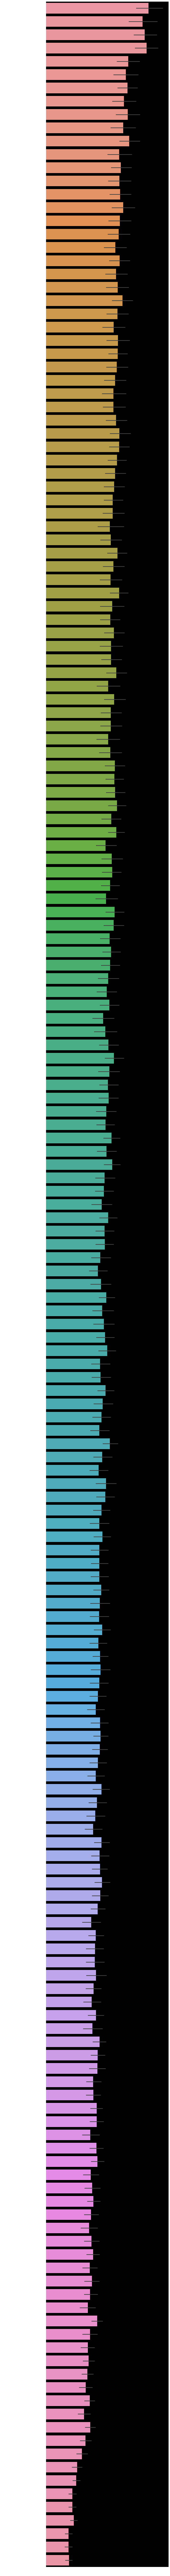

In [314]:
############ VARIABLE IMPORTANCE

# load importance    
top_feats = 300
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 150))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()
plt.savefig('./var_importance.pdf')

SUBMISSION

In [315]:
# file name
model = 'goss_v28_seed111'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf
name

'goss_v28_seed111_90795'

In [316]:
# export OOF preds
oof = pd.DataFrame({'encounter_id': train['encounter_id'], 'hospital_death': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,encounter_id,hospital_death
0,66154.0,0.037067
1,114252.0,0.455410
2,119783.0,0.001172
3,79267.0,0.029493
4,92056.0,0.002733


In [317]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(preds_test.reshape(-1,1))
preds_test = scaler.transform(preds_test.reshape(-1,1)).reshape(-1)

In [318]:
# export submission
sub = pd.DataFrame({'encounter_id': test['encounter_id'], 'hospital_death': preds_test})
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

,encounter_id,hospital_death
0,2,0.009557
1,5,0.017340
2,7,0.014965
3,8,0.145300
4,10,0.616420
